In [476]:
import numpy as np
from matplotlib import pyplot as plt

# IQ Sampling

Ziel dieses Notebooks ist es, ein Verständnis für die generierung und Abtastung von IQ-Samples zu entwickeln. Dabei soll Rauschen und der Einfluss des Kanals zunächst vernachlässigt werden. Der Fokus soll hier allein auf dem Verständnis liegen, wie IQ Samples von einem SDR versendet werden, als reales Signal übertragen werden und wie sie empfangen werden.

Am Ende des Notebooks sollte folgendes klar sein:

- Was sind IQ-Samples?
- Das Sendesignal wird immer komplex beschrieben. Übertragen wird jedoch nur der Realteil. Warum?
- Wie werden aus dem realen, analogen Empfangssignal die komplexen IQ-Samples gewonnen?
- Warum können der I- und Q-Teil überlagert ausgesendet werden und dennoch beim Empfänger getrennt werden?

## Theoretischer Background: TX und RX

### Transmitter

Der Transmitter (TX) erzeugt ein diskretes komplexes Basisband-Signal $s_{\text{NF}}[n]$, welches in der Regel als I/Q-Signal bezeichnet wird. Das I/Q-Signal besteht aus zwei Komponenten: der In-Phase-Komponente (I) und der Quadratur-Komponente (Q). Das I/Q-Signal $s_{\text{NF}}[n]$ wird dann auf eine Trägerfrequenz $f_{\text{c}}$ hochgemischt und als analoges Passband Signal $s_{\text{HF}}(t)$ übertragen.

-> hier bild einfügen


$$s_{\text{NF}}[n] = I[n] + j \text{ } Q[n]$$

* $I[n]$ ist die In-Phase-Komponente (Kosinus Anteil, Realteil)
* $Q[n]$ ist die Quadratur-Komponente (Sinus Anteil, Imaginärteil)
* Bsp.: QPSK-Sample
$$
\begin{align*}
s_{\text{QPSK}} &= 1 + j \\
                &= \sqrt{2} \text{ } e^{j\frac{\pi}{4}} \\
                &=  \sqrt{2} \cos(\frac{\pi}{4}) + j \sqrt{2}  \sin(\frac{\pi}{4}) \\
                &= I + j Q
                &= \sqrt{2} \left(\frac{\sqrt{2}}{2} + j \frac{\sqrt{2}}{2}\right) \\
                &= 1 + j
\end{align*}
$$
  * Der Imaginärteil ist also der Sinus-Anteil, der Realteil der Kosinus-Anteil

Werden die IQ-Samples vom ausgesendet, werden sie als reales Signal übertragen.

$$
                        s(t) = I(t) + j \text{ } Q(t) \text{ } e^{j 2 \pi f_{\text{c}} t} = I(t) \cos(2 \pi f_{\text{c}} t) - Q(t) \sin(2 \pi f_{\text{c}} t)
$$

Im SDR wird das wie im Blockschaltbild folgendermaßen realisiert:
Es wird ein Sinus generiert, welcher auf die Trägerfrequenz $f_{\text{c}}$ gemischt wird. Dieser wird dann zum einen mit der Imaginären Komponente (Q-Komponente) multipliziert. Und zum anderen wird auf ihn eine Phaseshift von 90° angewendet, das Vorzeichen umgekehrt und mit der realen Komponente (I-Komponente) multipliziert. Die beiden Signale werden dann addiert und ergeben das Sendesignal.

Bemerkung Orthogonalität: Die beiden Signale sind orthogonal zueinander, d.h. das Skalarprodukt ist 0. Das bedeutet, dass die beiden Signale unabhängig voneinander sind und der Empfänger die I und Q Komponenten aus der Summe extrahieren kann.
$$
    s_{\text{HF}}(t) = I(t) \cos(2 \pi f_{\text{c}} t) + Q(t) \sin(2 \pi f_{\text{c}} t)
$$

In [477]:
def generate_m_sequence_16bit():
    """
    Generiert eine 16 Bit lange M-Sequenz mit LFSR (Linear Feedback Shift Register)
    Verwendetes primitives Polynom: x^4 + x^3 + 1 (Taps an Position 3 und 4)
    """
    register = [1, 1, 1, 1]  # Initialzustand (darf nicht alle 0 sein)
    sequence = []

    for _ in range(16):
        # Feedback-Berechnung (XOR der Taps)
        feedback = register[3] ^ register[2]  # 0-indizierte Positionen
        sequence.append(register.pop())
        register.insert(0, feedback)

    return sequence


## Generierung des Sendesignals

Das Sendesignal wird aus den Datenbits und einer Synchronisationssequenz generiert. Die Synchronisationssequenz wird verwendet, um den Empfänger zu synchronisieren. Das Sendesignal wird dann mit einem Raised-Cosine Filter gepulst, um die Bandbreite des Signals zu begrenzen.

### Konvertierung der Datenbits $\vec{b}[i]$ in BPSK Samples

   $$
    \text{BPSK}(i) = \vec{b}[i] \cdot 2 - 1
   $$

Es sollen T = 8 Samples pro Symbol verwendet werden. Das Sendesignal wird dann wie folgt generiert:

$$
    x_{\text{NF, no shape}}[n] = \sum_{i=0}^{N-1} \text{BPSK}(i) \delta\left(n - i T\right)
$$

Für IQ-Modulation wird das für den I und Q Teil getrennt durchgeführt, somit ergibt sich:

$$
    x_{\text{I, no shape}}[n] = \Re\left\{x_{\text{NF, no shape}}[n]\right\}
$$
$$
    x_{\text{Q, no shape}}[n] = \Im\left\{x_{\text{NF, no shape}}[n]\right\}
$$

Im Falle von BPSK bleibt der Imaginärteil immer 0, da die BPSK Symbole nur auf der Realachse liegen, sodass hier nur $x_{\text{I, no shape}}[n]$ betrachtet wird.

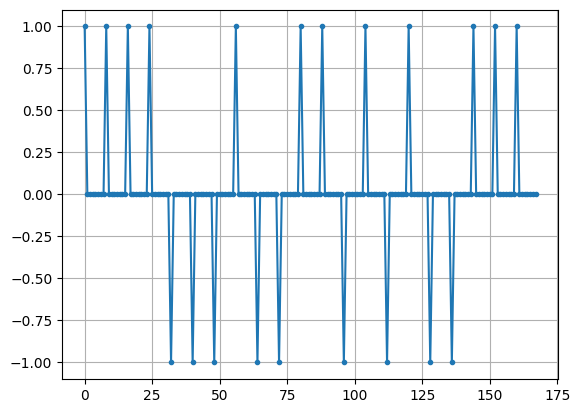

In [478]:
data_bits = np.array([0,0,1,1,1])


sps = 8 # symboldauer hat einfluss auf die bandbreite des basisbandsignals

syncronisation_sequence = generate_m_sequence_16bit()
bits = np.concatenate((syncronisation_sequence, data_bits))
num_symbols = len(bits)

x = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    x = np.concatenate((x, pulse)) # add the 8 samples to the signal
plt.figure(0)
plt.plot(x, '.-')
plt.grid(True)
plt.show()

(101,)


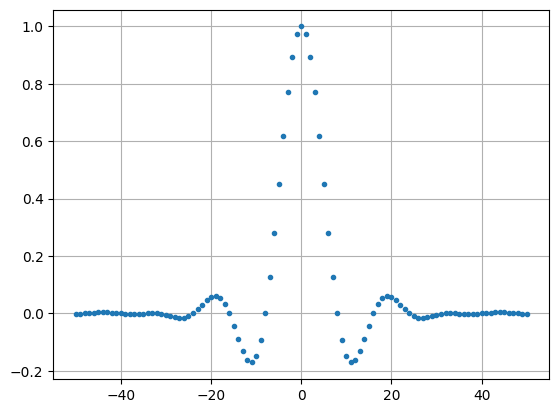

In [479]:
# Create our raised-cosine filter
num_taps = 101 # definiert die länge des filters
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(num_taps) - (num_taps-1)//2
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)
plt.figure(1)
plt.plot(t, h, '.')
plt.grid(True)
print(h.shape)
plt.show()

## Pulsformung

Das Sendesignal wird nun mit dem Raised-Cosine Filter gepulst. Das Sendesignal wird also mit dem Filter $h[n]$ gefaltet:

$$
    x_{\text{I, shaped}}[n] = x_\text{I}[n] * h_{\tiny{\text{Pulse Form}}}[n]
$$

$$
h_{\tiny{\text{Pulse Form}}}[n] = \text{sinc}\left(\frac{n}{T_s f_s}\right) \cdot \frac{\cos\left(\pi \beta \frac{n}{T_s f_s}\right)}{1 - \left(2 \beta \frac{n}{T_s f_s}\right)^2}
$$

where:
\begin{align*}
\text{sinc}(x) &= \frac{\sin(\pi x)}{\pi x} \\
T_s &= \text{symbol period} \\
\beta &= \text{roll-off factor} \\
f_s &= \text{sampling frequency}
\end{align*}


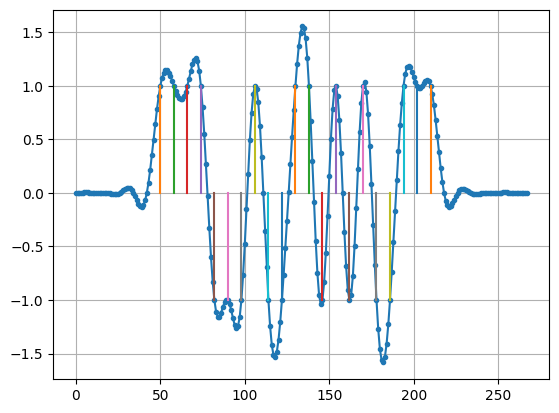

In [480]:
# Filter our signal, in order to apply the pulse shaping
x_shaped = np.convolve(x, h)
plt.figure(2)
plt.plot(x_shaped, '.-')
for i in range(num_symbols):
    # 2x die gleiche x korrdinate, dann von y= 0 bis zum wert
    plt.plot([i*sps+num_taps//2,i*sps+num_taps//2], [0, x_shaped[i*sps+num_taps//2]])
plt.grid(True)
plt.show()

In [481]:
x_shaped.shape

(268,)

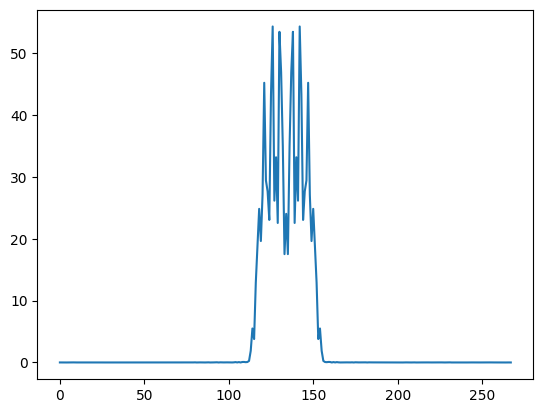

In [482]:
# shift zero frequency to the center
x_shaped_spectrum = np.fft.fftshift(np.fft.fft(x_shaped))
plt.plot(np.abs(x_shaped_spectrum))

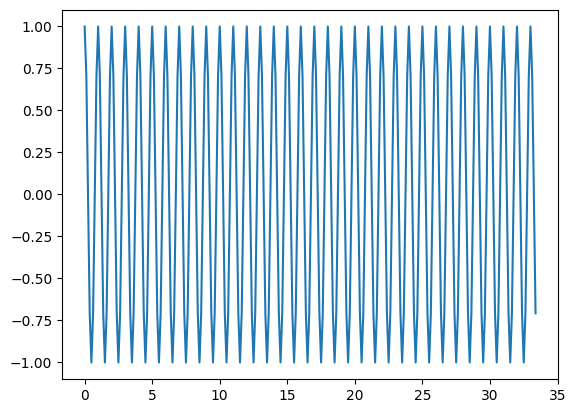

In [483]:
fc = 1  # Hz carrier frequency
fs = sps  # Hz sampling rate
t = np.arange(len(x_shaped)) / fs
carrier = np.cos(2 * np.pi * fc * t)
plt.plot(t, carrier)
plt.show()


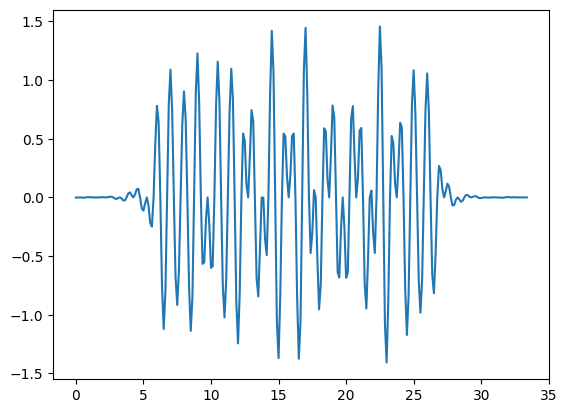

In [484]:
passband_signal = x_shaped * carrier
plt.plot(t, passband_signal)

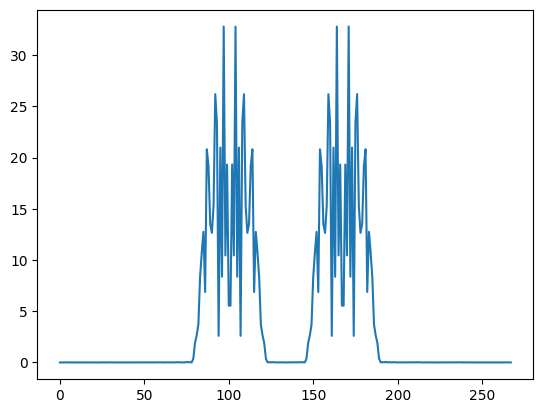

In [485]:
# spectrum of the passband signal
passband_signal_spectrum = np.fft.fftshift(np.fft.fft(passband_signal))
plt.plot(np.abs(passband_signal_spectrum))
plt.show()

## Empfänger

Bei der _Direct Downconversation_ (bild einfügen), wird vom Empfangssignal im SDR der I und Q Teil separat extrahiert. Nur so kann das reale Empfangssignal wieder in die komplexe Basisbandsignalform zurückgeführt werden.

* Extraktion des Q-Anteils:
$$
    \hat{Q}_{\tiny{\text{No Filter}}}(t) = s_{\text{HF}}(t) \cos(2 \pi f_{\text{c}} t) = \frac{1}{2} \text{ } I(t) \text{ } sin(4 \pi f_{\text{c}} t) - \frac{1}{2} \text{ } Q(t) \text{ } cos(4 \pi f_{\text{c}} t) +  \frac{1}{2} Q(t)
$$
Die hochfrequenten Anteile bei $2f_{\text{c}}$ und $-2f_{\text{c}}$ werden durch einen Tiefpassfilter eliminiert. Das Basisbandsignal $Q[n]$ wird dann durch eine Abtastung des Signals gewonnen.
$$
\hat{Q}_{\tiny{\text{LP}}}[n] \approx Q[n] \text{, mit } Q[n] = \sum_{k=0}^{N-1} Q[k] \delta\left(n - kT\right) * h_{\tiny{\text{Pulse Form}}}[n]
$$
$$
h_{\tiny{\text{Pulse Form}}}[n] = \text{sinc}\left(\frac{n}{T_s f_s}\right) \cdot \frac{\cos\left(\pi \beta \frac{n}{T_s f_s}\right)}{1 - \left(2 \beta \frac{n}{T_s f_s}\right)^2}
$$

where:
\begin{align*}
\text{sinc}(x) &= \frac{\sin(\pi x)}{\pi x} \\
T_s &= \text{symbol period} \\
\beta &= \text{roll-off factor} \\
f_s &= \text{sampling frequency}
\end{align*}


* Extraction of the I component:
$$
    \hat{I}_{\tiny{\text{No Filter}}}(t) = s_{\text{HF}}(t) \sin(2 \pi f_{\text{c}} t) = \frac{1}{2} \text{ } I(t) \text{ } \cos(4 \pi f_{\text{c}} t) + \frac{1}{2} \text{ } Q(t) \text{ } \sin(4 \pi f_{\text{c}} t) +  \frac{1}{2} I(t)
$$
Die hochfrequenten Anteile bei $2f_{\text{c}}$ und $-2f_{\text{c}}$ werden durch einen Tiefpassfilter eliminiert. Das Basisbandsignal $I[n]$ wird dann durch eine Abtastung des Signals gewonnen.
$$
\hat{I}_{\tiny{\text{LP}}}[n] \approx I[n] \text{, mit } I[n] = \sum_{k=0}^{N-1} I[k] \delta\left(n - kT\right) * h_{\tiny{\text{Pulse Form}}}[n]
$$
$$
h_{\tiny{\text{Pulse Form}}}[n] = \text{sinc}\left(\frac{n}{T_s f_s}\right) \cdot \frac{\cos\left(\pi \beta \frac{n}{T_s f_s}\right)}{1 - \left(2 \beta \frac{n}{T_s f_s}\right)^2}
$$

where:
\begin{align*}
\text{sinc}(x) &= \frac{\sin(\pi x)}{\pi x} \\
T_s &= \text{symbol period} \\
\beta &= \text{roll-off factor} \\
f_s &= \text{sampling frequency}
\end{align*}

Am Ende werden vom SDR die I und Q Komponenten wieder zu einem komplexen Signal zusammengefügt, dass im NumPy Array dann der Realteil eines Samples dessen I Sample enthält und der Imaginärteil dessen zugehörigen Q Sample enthält.

Ein Sample am Index $n$ eines NumPy Arrays enthält also die I und Q Komponente des $n$-ten Symbols:

$$
    \text{Array}[n] = I[n] + j \text{ } Q[n]
$$

In [486]:
# Receiver
# Downconvert the signal
downconverted_signal = passband_signal * carrier

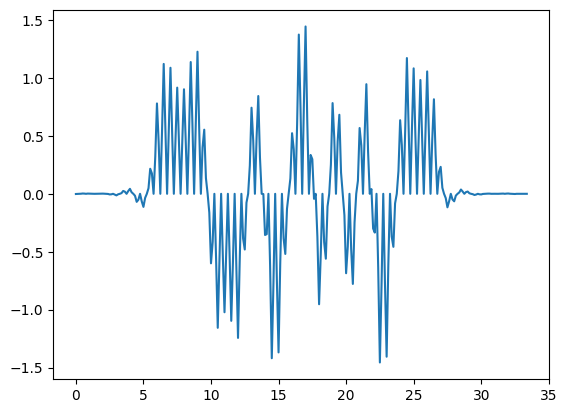

In [487]:
plt.plot(t, downconverted_signal)

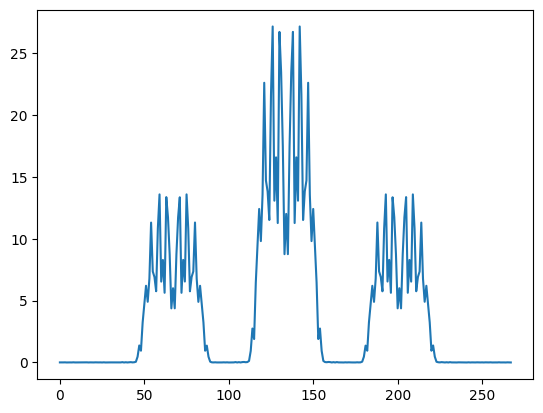

In [488]:
# spectrum of the downconverted signal
downconverted_signal_spectrum = np.fft.fftshift(np.fft.fft(downconverted_signal))
plt.plot(np.abs(downconverted_signal_spectrum))
plt.show()

In [489]:
len(downconverted_signal)

268

268


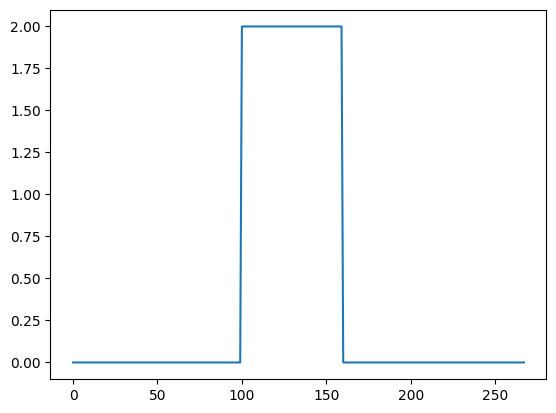

In [490]:
# tiefpassfilter um das basisbandsignal zu erhalten -> eliminiere frequenzen größer +- fc

f = np.fft.fftfreq(len(downconverted_signal), 1/fs)

print(len(f))

rect = np.zeros(len(f))
# correct the 1/2 factor from downconversion

# TODO: Calculate the Nyquist frequency and set the cutoff frequency to 1/4 of the Nyquist frequency
rect[100:160] = 1
rect = rect * 2
plt.plot(rect)


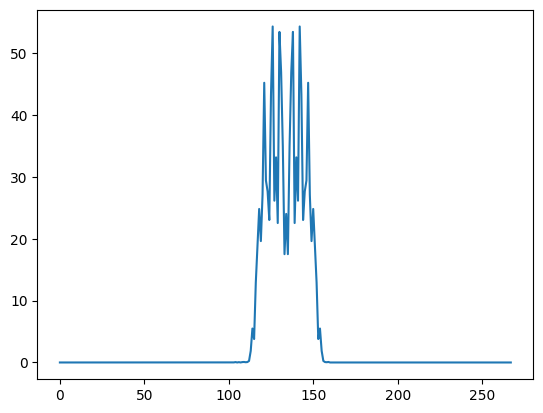

In [491]:
downconverted_filtered_spectrum = downconverted_signal_spectrum * rect
plt.plot(np.abs(downconverted_filtered_spectrum))

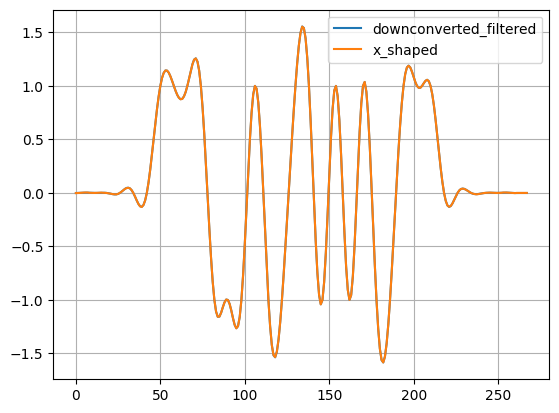

In [492]:
# Frequenzbereichsfilterung durchführen
downconverted_filtered = np.fft.ifft(np.fft.ifftshift(downconverted_filtered_spectrum))

plt.plot(downconverted_filtered)
plt.plot(x_shaped)
plt.grid(True)
plt.legend(['downconverted_filtered', 'x_shaped'])

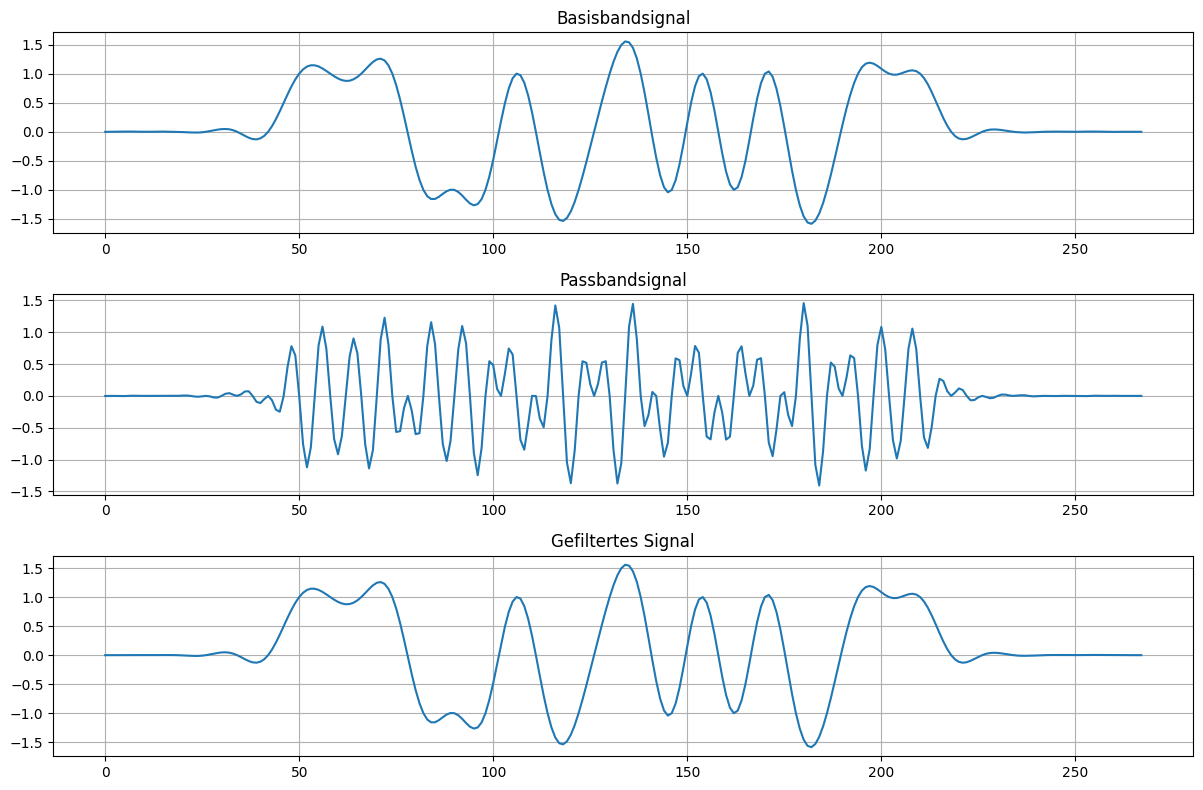

In [493]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(x_shaped)
plt.title("Basisbandsignal")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(passband_signal)
plt.title("Passbandsignal")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(downconverted_filtered)
plt.title("Gefiltertes Signal")
plt.grid(True)

plt.tight_layout()
plt.show()

(-25.0, 25.0)

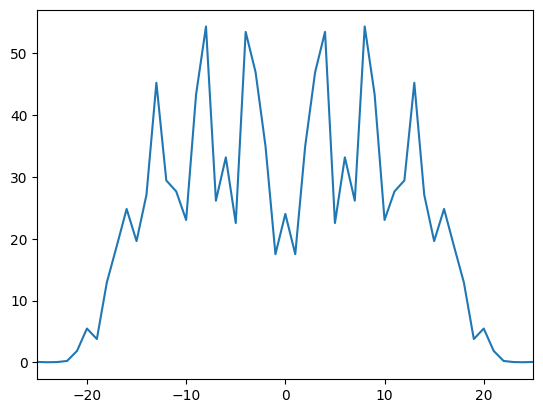

In [494]:
# Sample the signal
f_bins = np.arange(0, len(downconverted_filtered)) - len(downconverted_filtered)//2
plt.plot(f_bins, np.fft.fftshift(np.abs(np.fft.fft(downconverted_filtered))))
plt.xlim(-25,25)

In [512]:
fs = sps

# Das ist nun der I Teil des empfangenen Signals
rx_sampled = downconverted_filtered[::fs].real

# Das SDR liefert nun daraus ein NumpPy Array mit dem dtype complex64
rx_sampled = rx_sampled.astype(np.complex64)


In [513]:
print(rx_sampled)

[-6.3243642e-04+0.j  2.1456133e-03+0.j  1.9191514e-03+0.j
 -1.3164127e-02+0.j  4.2475071e-02+0.j -1.1337830e-01+0.j
  7.7971178e-01+0.j  1.0887400e+00+0.j  9.0225226e-01+0.j
  1.2265912e+00+0.j -5.9991944e-01+0.j -1.0224222e+00+0.j
 -1.2451038e+00+0.j  7.4410856e-01+0.j -3.5623658e-01+0.j
 -1.3696188e+00+0.j  5.2284259e-01+0.j  1.4446360e+00+0.j
 -9.5283782e-01+0.j  7.8403181e-01+0.j -6.8521684e-01+0.j
  5.6813842e-01+0.j -2.9973850e-01+0.j -1.4066094e+00+0.j
  6.3571423e-01+0.j  1.0829862e+00+0.j  1.0570905e+00+0.j
  2.3284133e-01+0.j -6.4599268e-02+0.j  1.9451907e-02+0.j
 -5.5056177e-03+0.j  4.6344503e-04+0.j  2.5291089e-03+0.j
 -3.1178893e-04+0.j]


# Ende des Notebooks, Nachfolgender Teil kommt in die Synchronisation

In [505]:
rx_sampled


array([-6.32436437e-04,  2.14561324e-03,  1.91915136e-03, -1.31641273e-02,
        4.24750724e-02, -1.13378298e-01,  7.79711784e-01,  1.08874001e+00,
        9.02252280e-01,  1.22659129e+00, -5.99919431e-01, -1.02242222e+00,
       -1.24510387e+00,  7.44108547e-01, -3.56236568e-01, -1.36961874e+00,
        5.22842597e-01,  1.44463602e+00, -9.52837818e-01,  7.84031836e-01,
       -6.85216829e-01,  5.68138417e-01, -2.99738502e-01, -1.40660937e+00,
        6.35714230e-01,  1.08298626e+00,  1.05709055e+00,  2.32841327e-01,
       -6.45992666e-02,  1.94519070e-02, -5.50561754e-03,  4.63445042e-04,
        2.52910878e-03, -3.11788914e-04])

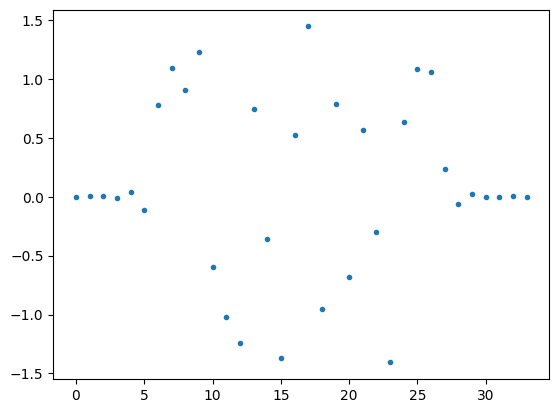

In [506]:
plt.plot(rx_sampled, '.')

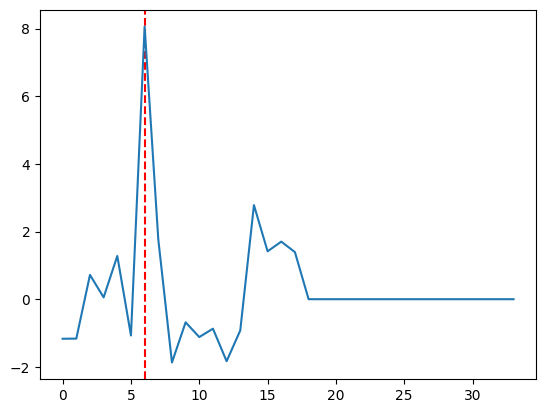

In [507]:
corr = np.zeros(len(rx_sampled))

for i in range(len(rx_sampled) - len(syncronisation_sequence)):
    corr[i] = np.dot(rx_sampled[i:i+len(syncronisation_sequence)], syncronisation_sequence)

tau0 = np.argmax(np.abs(corr))
plt.axvline(tau0, color='r', linestyle='--')
plt.plot(corr)

In [508]:
print(f"tau0: {tau0}")
print(f"rx len: {len(rx_sampled)}")


tau0: 6
rx len: 34


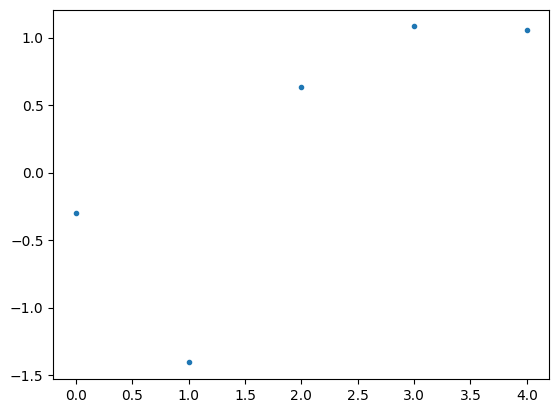

In [509]:
# data bits start at tau0 + len(syncronisation_sequence) and end at tau0 + len(syncronisation_sequence) + len(data_bits)
data_symbols_received = rx_sampled[tau0+len(syncronisation_sequence):tau0+len(syncronisation_sequence)+len(data_bits)]
plt.plot(data_symbols_received, '.')

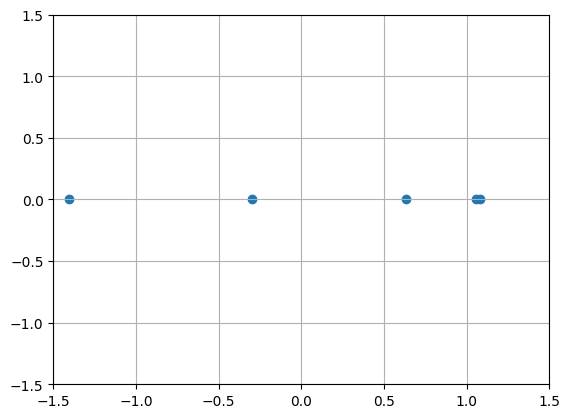

In [510]:
# iq plot
plt.scatter(np.real(data_symbols_received), np.imag(data_symbols_received))
plt.ylim(-1.5, 1.5)
plt.xlim(-1.5, 1.5)
plt.grid(True)


In [511]:
# decision making
data_bits_received = np.zeros_like(data_bits)
for i, symbol in enumerate(data_symbols_received):
    if symbol.real > 0:
        data_bits_received[i] = 1
    else:
        data_bits_received[i] = 0

print("bits^hat = ", data_bits_received)
print("bits     = ", data_bits)

bits^hat =  [0 0 1 1 1]
bits     =  [0 0 1 1 1]
